In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,RocCurveDisplay,auc,plot_confusion_matrix,confusion_matrix,f1_score,balanced_accuracy_score,make_scorer
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

rs = 271828

1. One-hot encoder (categorical)
1. Train/Test split
2. missing value imputation
3. baseline model
    * Decision Tree Classifier
5. balance data set
    * SMOTE
    * Undersampling    
4. new features
    * Featuretools
    * PCA
    * AutoEncoder?
6. Modeling
    * Randomforest Classifer
    * XGBoost Classifier
    * Logistic Regression
    * Keras Classifier
7. Pipeline?
8. Streamlit?

In [2]:
df = pd.read_csv('data/abalone2.csv')

# 1. Create one-hot variable for categorical sex feature
#    remove original sex feature
df[['infant','male']] = pd.get_dummies(df.sex,drop_first=True)
del df['sex']

# Make 0.0 np.nan so that we can impute later
df.loc[df.height==0.,'height'] = np.nan

# Remove rings from X vector (this is a version of the respons)
x_features = ['length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight','infant','male']
X = df.loc[:,x_features]
y = df.loc[:,['y']]

# 2. Split the data set into Train/Test split
test_pct = 0.3
rs = 271828
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_pct, random_state=rs)

print(f'X vector shape: {X.shape}')
print(f'y vector shape: {y.shape}')
print('-'*20)
print('Train/Test Split')
print(f'test pct: {test_pct:.2%}')
print('-'*20)
print(f'Train X: {X_train.shape}\tTrain y: {y_train.shape}')
print(f'Test X: {X_test.shape}\tTest y: {y_test.shape}')

X vector shape: (4177, 9)
y vector shape: (4177, 1)
--------------------
Train/Test Split
test pct: 30.00%
--------------------
Train X: (2923, 9)	Train y: (2923, 1)
Test X: (1254, 9)	Test y: (1254, 1)


In [3]:
# 3. Impute missing values
imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train),index=X_train.index,columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test),index=X_test.index,columns=X_test.columns)

X_train.loc[df.height.isna(),:]
X_test.loc[df.height.isna(),:]

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,infant,male
3996,0.315,0.23,0.096,0.134,0.0575,0.0285,0.3505,1.0,0.0
1257,0.430,0.34,0.117,0.428,0.2065,0.0860,0.1150,1.0,0.0


,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,infant,male


In [10]:
def get_classification_metrics(model,X_train,y_train,X_test,y_test,model_name='default'):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_prob = model.predict_proba(X_train)[:,1]
    test_prob = model.predict_proba(X_test)[:,1]
    
    train_scores = classification_report(y_train,train_pred,output_dict=True)
    test_scores = classification_report(y_test,test_pred,output_dict=True)
    
    train_scores = pd.DataFrame(train_scores).T
    test_scores = pd.DataFrame(test_scores).T
    train_scores['model'] = model_name
    test_scores['model'] = model_name
    train_scores['split'] = 'train'
    test_scores['split'] = 'test'
    
    train_roc = roc_curve(y_train,train_prob,drop_intermediate=False)
    test_roc = roc_curve(y_test,test_prob,drop_intermediate=False)
    
    train_auc = auc(train_roc[0],train_roc[1])
    test_auc = auc(test_roc[0],test_roc[1])
    
    lw=2
    plt.plot(train_roc[0],train_roc[1],label=f'Train - AUC: {train_auc:.2f}',lw=lw)
    plt.plot(test_roc[0],test_roc[1],label=f'Test - AUC: {test_auc:.2f}',lw=lw)
    plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),label='No Skill',c='black',linestyle='--',lw=lw)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Reciever Operator Characteristic Curve\n{model_name}')
    plt.plot()
    plt.legend()
    plt.show()
    
    sns.heatmap(
        confusion_matrix(y_test,test_pred),
        annot=True,
        cmap='Blues',
        fmt='d'
    )
    plt.title(f'Confusion Matrix - Test\n{model_name}')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.grid(False)
    plt.show()
    
    return pd.concat([train_scores,test_scores])

LogisticRegression()

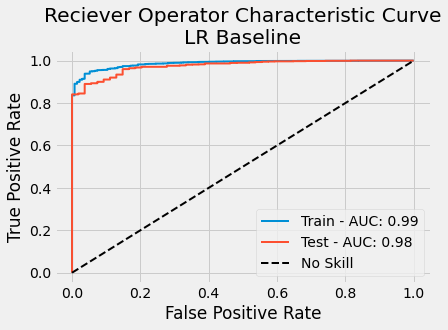

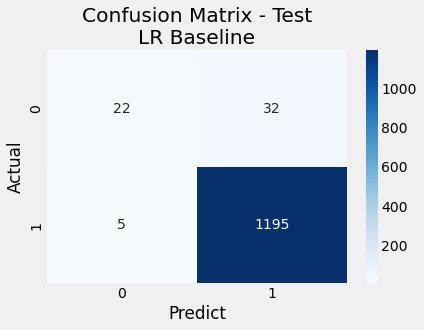

,precision,recall,f1-score,support,model,split
0,0.814815,0.407407,0.543210,54.000000,LR Baseline,test
1,0.973920,0.995833,0.984755,1200.000000,LR Baseline,test
accuracy,0.970494,0.970494,0.970494,0.970494,LR Baseline,test
0,0.896104,0.511111,0.650943,135.000000,LR Baseline,train
1,0.976810,0.997131,0.986865,2788.000000,LR Baseline,train
accuracy,0.974684,0.974684,0.974684,0.974684,LR Baseline,train


In [19]:
scores = []
lr_baseline = LogisticRegression()
lr_baseline.fit(X_train.values,y_train.values.ravel())
scores.append(get_classification_metrics(lr_baseline,X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model_name='LR Baseline'))

pd.concat(scores).loc[['0','1','accuracy'],:].sort_values(['split'])

In [20]:
# put a note here about f1score ect

Pipeline(steps=[('smote', SMOTE()),
                ('logisticregression', LogisticRegression())])

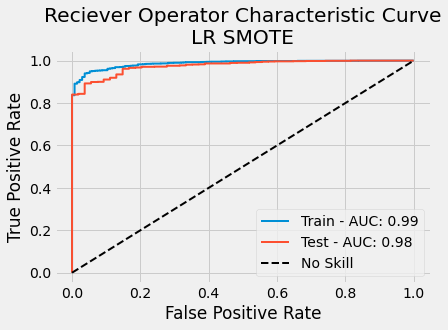

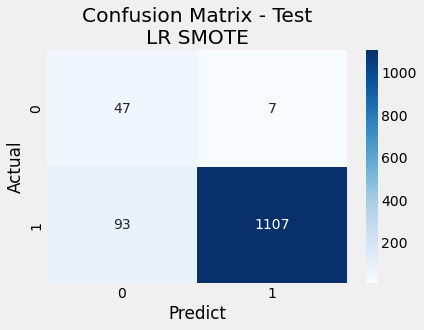

In [21]:
# SMOTE Only
lr_smote = LogisticRegression()
over = SMOTE()

model = make_pipeline(over,lr_smote)
model.fit(X_train.values,y_train.values.ravel())
scores.append(get_classification_metrics(model,X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model_name='LR SMOTE'))

Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.2)),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy=0.2)),
                ('logisticregression', LogisticRegression())])

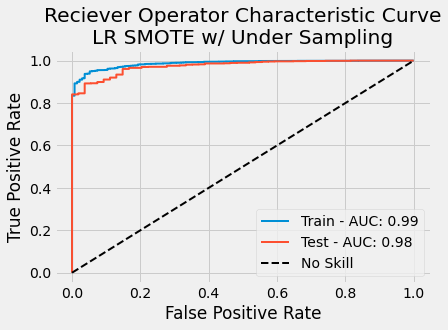

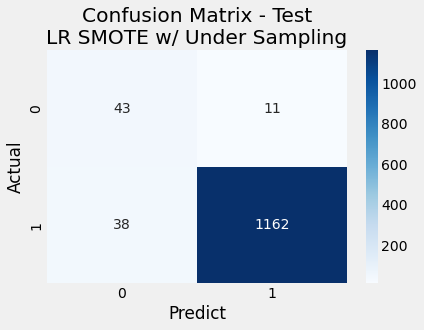

In [22]:
# SMOTE and Under Sampling
lr_smote = LogisticRegression()
over = SMOTE(sampling_strategy=0.20)
under = RandomUnderSampler(sampling_strategy=0.20)
model = make_pipeline(over,under,lr_smote)
model.fit(X_train.values,y_train.values.ravel())
scores.append(get_classification_metrics(model,X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model_name='LR SMOTE w/ Under Sampling'))

Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.2)),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy=0.2)),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression', LogisticRegression())])

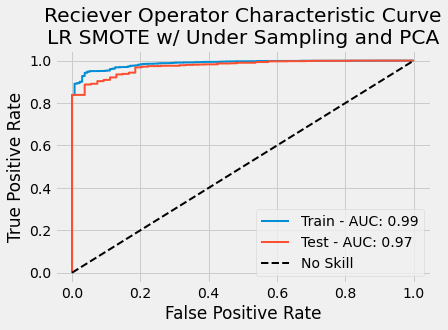

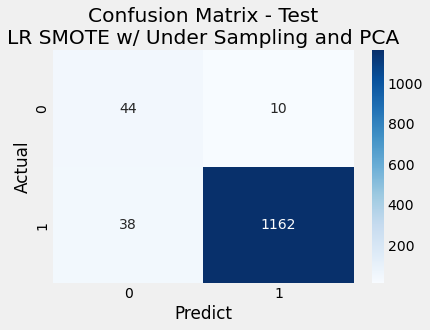

In [23]:
# SMOTE and Under Sampling AND PCA :)
lr_smote = LogisticRegression()
pca = PCA(n_components=0.95)
over = SMOTE(sampling_strategy=0.20)
under = RandomUnderSampler(sampling_strategy=0.20)

model = make_pipeline(over,under,pca,lr_smote)
model.fit(X_train.values,y_train.values.ravel())
scores.append(get_classification_metrics(model,X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model_name='LR SMOTE w/ Under Sampling and PCA'))

In [29]:
scores = pd.concat(scores)
scores[scores.split=='test'].loc[['0',],:].sort_values(['f1-score'],ascending=False)

,precision,recall,f1-score,support,model,split
0,0.536585,0.814815,0.647059,54.0,LR SMOTE w/ Under Sampling and PCA,test
0,0.530864,0.796296,0.637037,54.0,LR SMOTE w/ Under Sampling,test
0,0.814815,0.407407,0.543210,54.0,LR Baseline,test
0,0.335714,0.870370,0.484536,54.0,LR SMOTE,test


<AxesSubplot:xlabel='y', ylabel='count'>

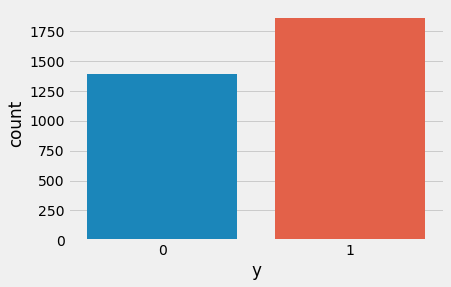

In [16]:
over = SMOTE(sampling_strategy=0.50)
under = RandomUnderSampler(sampling_strategy=0.75)
X_train_sample, y_train_sample = over.fit_resample(X_train,y_train)
X_train_sample, y_train_sample = under.fit_resample(X_train_sample, y_train_sample)

sns.countplot(x=y_train_sample.y)

In [34]:
from tpot import TPOTClassifier

pipeline_optimizer = TPOTClassifier(generations=20, population_size=20, verbosity=2,)
pipeline_optimizer.fit(X_train_sample.values, y_train_sample.values.ravel())

pipeline_optimizer.export('models/tpot-clf.py')

Optimization Progress:   0%|          | 0/420 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9673978494623656

Generation 2 - Current best internal CV score: 0.9680170152428218

Generation 3 - Current best internal CV score: 0.9710929930284768

Generation 4 - Current best internal CV score: 0.9717074323525935

Generation 5 - Current best internal CV score: 0.9717074323525935

Generation 6 - Current best internal CV score: 0.9735516956162117

Generation 7 - Current best internal CV score: 0.9735516956162117

Generation 8 - Current best internal CV score: 0.9735516956162117

Generation 9 - Current best internal CV score: 0.9735516956162117

Generation 10 - Current best internal CV score: 0.9735516956162117

Generation 11 - Current best internal CV score: 0.9744766631218245

Generation 12 - Current best internal CV score: 0.9744766631218245

Generation 13 - Current best internal CV score: 0.9744766631218245

Generation 14 - Current best internal CV score: 0.976628618693135

Generation 15 - Current best internal CV score: 0.9769339

TPOTClassifier(generations=20, population_size=20, verbosity=2)

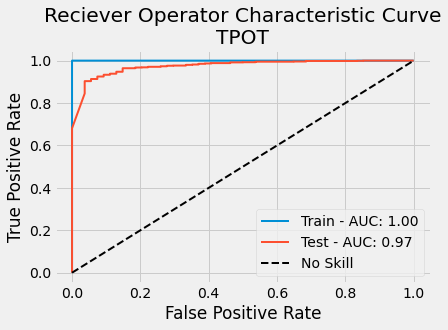

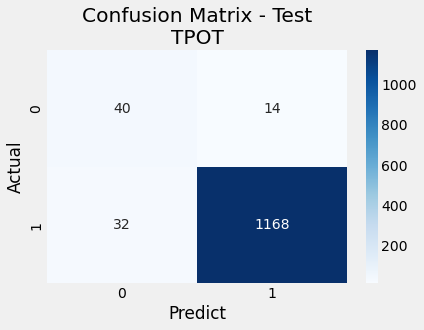

,precision,recall,f1-score,support,model,split
0,1.000000,1.000000,1.000000,1394.000000,TPOT,train
1,1.000000,1.000000,1.000000,1858.000000,TPOT,train
accuracy,1.000000,1.000000,1.000000,1.000000,TPOT,train
macro avg,1.000000,1.000000,1.000000,3252.000000,TPOT,train
weighted avg,1.000000,1.000000,1.000000,3252.000000,TPOT,train
0,0.555556,0.740741,0.634921,54.000000,TPOT,test
1,0.988156,0.973333,0.980688,1200.000000,TPOT,test
accuracy,0.963317,0.963317,0.963317,0.963317,TPOT,test
macro avg,0.771856,0.857037,0.807805,1254.000000,TPOT,test
weighted avg,0.969527,0.963317,0.965799,1254.000000,TPOT,test


In [35]:
get_classification_metrics(
    pipeline_optimizer,
    X_train_sample.values,y_train_sample.values.ravel(),
    X_test.values,y_test.values.ravel(),
    model_name=f'TPOT'
)